# Destinations [#audience]

We chose eight of our favorite coffee houese in the Berlin. We chose these because, as Minervans, we spend a lot of time working in different cafes throughout the city, but it can sometimes be hard to find cafe's with good coffee and reliable wifi. So, we thought we could do a service to future generations of Minervans in Berlin by preparing this list and finding the optimal path to visit all of them. We call this the cafe tour.

Berlin is one of the centers in the world's third wave coffee culture. As such, there are many cafes in Berlin that is known for its specialty coffee. The following 8 sites are some of Gordon's favorite coffeee spots in Berlin, in additional to classical Minervan spots. Bonanza Coffee Roasters removed wifi from the site after a previous class occupied the cafe. Milch and Zucher and The Visit has became Minervan's new swarming spots near the residence hall. 

1. THE BARN Café Neukölln
2. Milch and Zucher
3. Bonanza Coffee Roasters
4. Five Elephants Kreuzberg
5. The Visit Cafe
6. Father Carpenter
7. Hallesches Haus
8. Michelberger Hotel

# Travel Times [#evidencebased]

To fully formulate the traveling salesman problem, we needed data on the time required to bike between each pair of cafes. Due to the recent surge in COVID cases, we decided the safest way to collect this data was using Google maps. Many Minervans own bikes in Berlin. So, we thought bike times were probably most relevant to future classes.

Fig. 1 displays a graph of the cafes along with the estimated biking time between each pair.

**Figure 1.** *Cafes with estimated biking times in minutes*

![graph](imgs/graph.png)

# TSP Formulation [#optimizationstrategy, #constrained, #algorithms]

Our goal with this assignment was the find the route from the residence hall through all 8 cafes that takes the minimum time to bike. To do this, we think about the problem as a graph traversal problem---the problem of finding the shortest path through the graph of cafes which visits every cafe. Then, we can formulate this problem as an integer programming problem with a number of constraints.

## Constraints

To formulate this project as an integer programming problem, we need to describe possible routes in terms of integer valued variables. We define a design variables $x_ij$ for each pairs of nodes $i$ and $j$. This design variable takes on the value $1$ if the route goes directly from $i$ to $i$, and it is zero otherwise. We add the constraint:

$$
x_{ij} \in \{0, 1\}
$$

We need to constrain the values of the funtion to ensure that every node it visited at least once. We can do this by adding these contraints:

$$\sum_{i=0}^n x_ij = 1$$
$$\sum_{j=0}^n x_ij = 1$$

These say that the route must enter and leave each node exactly once.

This ensures that the route visits every node exactly once, but it allows for the possibility of subtours. To prevent this, we use black magic. We introduce a new set of integer valued design variables $u_i$ for $i \in \{1..n\}$. Then, we add the following two constraints:

$$u_i > 0$$

And, for all $i, j$ where $i \ne j$:
$$u_i - u_j + nx_{ij} \le n - 1$$

This constraints ensures that no there are no subtours in the final answer.

## Objective

We want to find an expression for the cost of a route desribed by the design variables $x_{ij}$. Let $c_{ij}$ represent the cost of traveling from node $i$ to node $j$ in the network. Then, the cost of the route will be:

$$
cost = \sum_{i, j \in \{1..n\}}x_{ij}c_{ij}
$$

This expression looks at every edge which we could travel and asks if we travel it as part of the route. It adds up the costs of all the routes we take.

# Optimal Solution [#optimization]



# Alternative Formulations & Comparison

In order to check the accuracy of our solution, we compare this result to an anlysis of the problem using two other optimization methods: ant colony optimization and brute force search. Since we are solving the traveling salesman for a case with only 8 cafes, the problem is actually small enough to brute force. There are $8! = 40,302$ distinct paths through all eight cafes, starting and ending at the res hall. So, we can simply iterate over these and see which is cheapest.

## Appendix: Code

In [39]:
import numpy as np
import networkx as nx
import cvxpy as cp
import matplotlib.pyplot as plt
import itertools

In [43]:
cafes = ['A&O Hostels', 'Bonanza Coffee Roasters', 'Milch and Zucher Oranienstraße', 'The Visit Coffee Roasters', 'Five Elephants Kreuzberg', 'The Barn Cafe Neukölln', 'Michelberger Hotel', 'Father Carpenter', 'Hallesches Haus']
cost = np.array([
    [ 0,  4,  4,  4, 11,  9, 11, 11, 13],
    [ 5,  0,  4,  4, 12, 10, 15, 16, 14],
    [ 4,  5,  0,  1,  8,  6, 14, 13, 10],
    [ 4,  4,  1,  0,  8,  5, 13, 14,  9],
    [11, 12,  9,  8,  0,  3, 10, 21, 15],
    [ 8,  9,  6,  5,  3,  0, 13, 20, 12],
    [ 7, 11, 10, 10,  8, 11,  0, 15, 18],
    [10, 14, 12, 14, 20, 18, 18,  0, 18],
    [14, 13,  7,  9, 15, 11, 21, 16,  0]
])

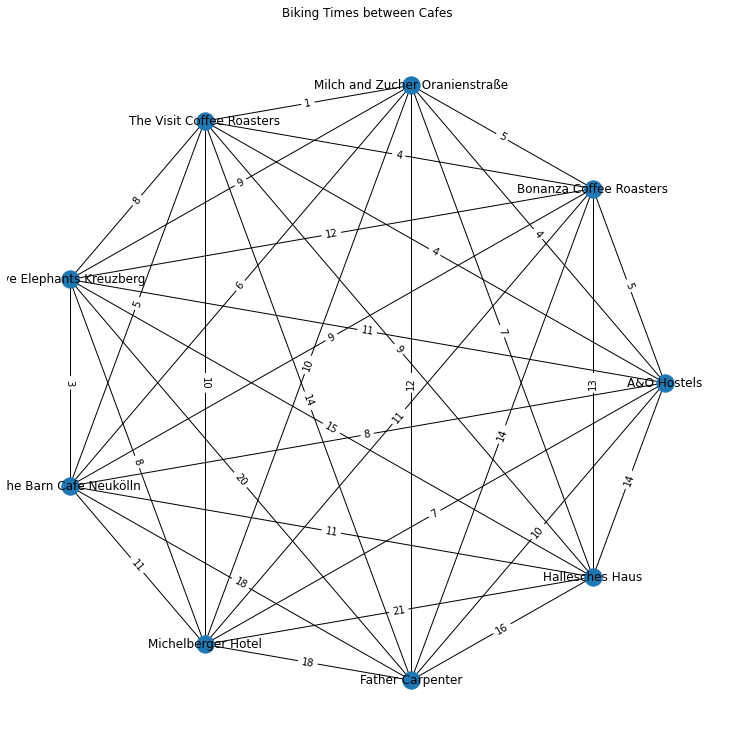

In [17]:
g = nx.from_numpy_array(cost)
g = nx.relabel_nodes(g, dict(enumerate(cafes)))

plt.figure(figsize=(10,10))
pos = nx.circular_layout(g)
nx.draw(g, pos=pos, with_labels=True)
nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=nx.get_edge_attributes(g, 'weight'))

plt.title("Biking Times between Cafes")
plt.savefig("imgs/graph.png")

In [18]:
def integer_programming(names, cost):
    """Solves the traveling salesman problem using CVXPY and integer programming."""

    n = cost.shape[0]

    # route matrix
    X = cp.Variable(cost.shape, boolean = True)

    # surrograte variables
    u = cp.Variable(n, integer = True)

    # objective function
    objective = cp.Minimize(cp.sum(cp.multiply(cost, X)))

    #define constraints
    ones = np.ones(n)
    constraints = [
        # each node must be visited exactly once
        X @ ones == ones,
        X.T @ ones == ones,

        # no self-loops
        cp.diag(X) == 0,

        #The first variable is the starting point (A&O Hostels)
        u[0] == 1,
        u[1:] >= 2,
        u[1:] <= n,
    ]

    # subtour elimination constraints
    for i in range(1,n):
        for j in range(1,n):
            if i != j:
                constraints.append(u[i] - u[j] + n*X[i,j] <= n-1)
    
    # Define and solve the CVXPY problem.
    prob = cp.Problem(objective,
                    constraints)
    result = prob.solve()

    # convert the result to a list of visited nodes
    one_steps = []
    for i in range(0,9):
        for j in range(0,9):
            if solution.value[i,j] == 1:
                one_steps.append([i,j])
    
    # turn matrix into list of cafes
    pos = 0
    order = [names[0]]
    while True:
        for edge in one_steps:
            if edge[0] == pos:
                pos = edge[1]
                break
        order.append(names[pos])

        if pos == 0:
            break

    return order

integer_programming(cafes, cost)

['A&O Hostels',
 'Bonanza Coffee Roasters',
 'Milch and Zucher Oranienstraße',
 'The Visit Coffee Roasters',
 'Hallesches Haus',
 'The Barn Cafe Neukölln',
 'Five Elephants Kreuzberg',
 'Michelberger Hotel',
 'Father Carpenter',
 'A&O Hostels']

Long-step dual simplex will be used


In [49]:
def brute_force(cafes, g):
    best_cost = np.inf
    best_route = None

    # iterate over possible routes
    for route in itertools.permutations(cafes[1:]):

        # calculate cost of route
        route_cost = 0
        position = cafes[0]
        for next in list(route) + [cafes[0]]:
            route_cost += g.edges[position, next]["weight"]
            position = next
        
        # check if this is the new winner
        if route_cost < best_cost:
            best_cost = route_cost
            best_route = [cafes[0]] + list(route) + [cafes[0]]
    
    return best_route, best_cost

best_route, best_cost = brute_force(cafes, g)

print(f"Best route: {best_route}")
print(f"Cost: {best_cost}")

Best route: ['A&O Hostels', 'Michelberger Hotel', 'Five Elephants Kreuzberg', 'The Barn Cafe Neukölln', 'Bonanza Coffee Roasters', 'The Visit Coffee Roasters', 'Milch and Zucher Oranienstraße', 'Hallesches Haus', 'Father Carpenter', 'A&O Hostels']
Cost: 65
